## Let's visualize the relationships between different metrics

In [12]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix

In [13]:
con = sqlite3.connect("../datasets/checking-logs.sqlite")

#### Create a dataframe where each user of the test group has the average difference, number of pageviews and number of commits

In [14]:
#create_datamart = """
#CREATE TABLE IF NOT EXISTS datamart AS
#WITH 
#filt_checker AS (
#    SELECT 
#        uid, 
#        labname, 
#        timestamp AS first_commit_ts
#    FROM checker
#    WHERE status = 'ready'
#      AND NumTrials = 1
#      AND labname IN ('laba04', 'laba04s', 'laba05', 'laba06', 'laba06s', 'project1')
#),
#filt_pageviews AS (
#    SELECT 
#        uid, 
#        MIN(datetime) AS first_view_ts
#    FROM pageviews
#    WHERE uid LIKE 'user_%'
#    GROUP BY uid
#)
#SELECT 
#    c.uid, 
#    c.labname,  
#    c.first_commit_ts,  
#    p.first_view_ts     
#FROM filt_checker c
#LEFT JOIN filt_pageviews p ON c.uid = p.uid;
#"""

#con.execute(create_datamart)

#sql = """
#SELECT *
#FROM datamart
#"""
#datamart = pd.read_sql(sql, con, parse_dates=['first_commit_ts', 'first_view_ts'])
#test = datamart[datamart['first_view_ts'].notna()].copy()
#print(test)
#test.to_sql('test', con, if_exists='replace', index=False)


In [15]:
sql = """
WITH daily_commits AS (
    SELECT uid, COUNT(*) AS commits
    FROM checker
    WHERE labname != 'project1'
    GROUP BY UID
),
daily_views AS (
    SELECT uid, COUNT(*) AS views
    FROM pageviews
    WHERE uid LIKE 'user_%'
    GROUP BY uid)
SELECT t.uid, avg((strftime('%s', first_commit_ts) - d.deadlines)/3600) as df_avg, views, commits
FROM test t
LEFT JOIN deadlines d on t.labname = d.labs
LEFT JOIN daily_views v on t.uid = v.uid
LEFT JOIN daily_commits c on t.uid = c.uid
WHERE labname != 'project1'
GROUP BY t.uid
"""


df = pd.read_sql(sql, con)
print(df)


        uid      df_avg  views  commits
0    user_1  -64.400000     28       62
1   user_10  -74.800000     89       20
2   user_14 -159.000000    143       61
3   user_17  -61.600000     47       51
4   user_18   -5.666667      3        5
5   user_19  -98.750000     16      118
6   user_21  -95.500000     10       65
7   user_25  -92.600000    179       79
8   user_28  -86.400000    149       60
9    user_3 -105.400000    317       18
10  user_30 -145.250000      3       34


#### Creating graphs

array([[<Axes: xlabel='df_avg', ylabel='df_avg'>,
        <Axes: xlabel='views', ylabel='df_avg'>,
        <Axes: xlabel='commits', ylabel='df_avg'>],
       [<Axes: xlabel='df_avg', ylabel='views'>,
        <Axes: xlabel='views', ylabel='views'>,
        <Axes: xlabel='commits', ylabel='views'>],
       [<Axes: xlabel='df_avg', ylabel='commits'>,
        <Axes: xlabel='views', ylabel='commits'>,
        <Axes: xlabel='commits', ylabel='commits'>]], dtype=object)

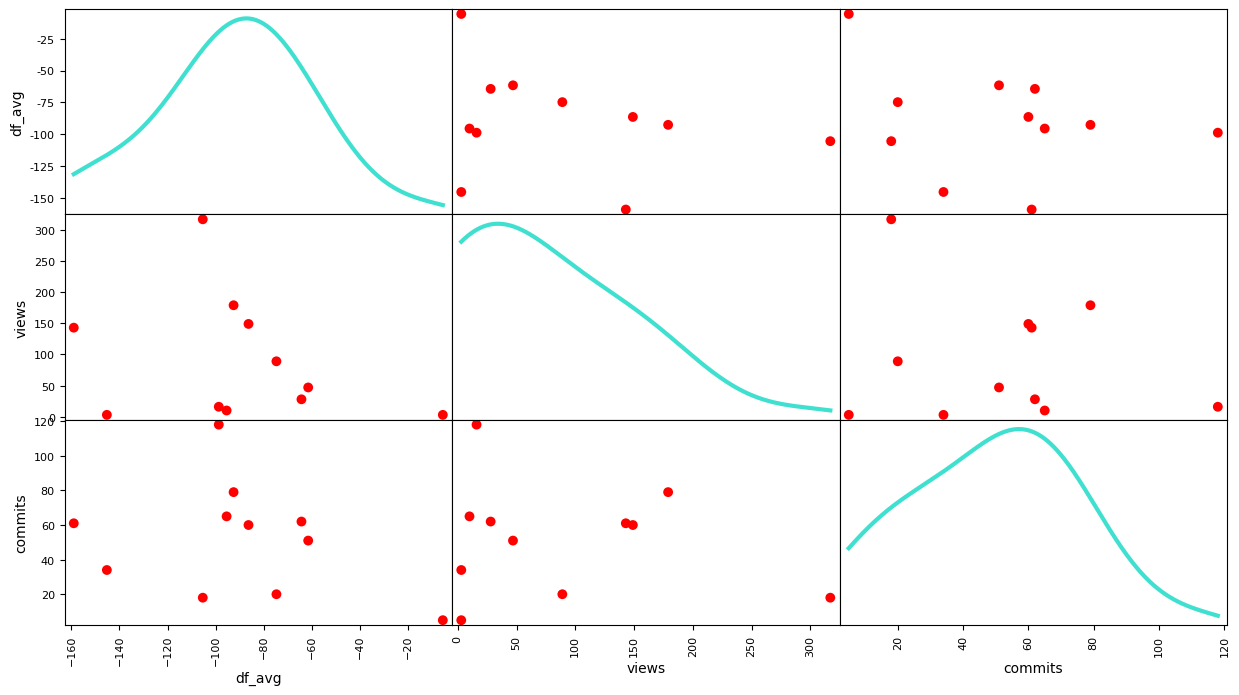

In [16]:
scatter_matrix(
    df[['df_avg', 'views', 'commits']], 
    figsize=(15,8),
    diagonal='kde',
    s=200, 
    alpha=1,
    color='red', 
    density_kwds={'linewidth': 3, 'color': 'turquoise'} 
)

#### Can we say that if a user has a low number of pageviews then they likely have a low number of commits? - NO

#### Can we say that if a user has a low number of pageviews then they likely have a small average difference between the first commit and the lab deadline? - NO

#### Can we say that there are many users with a low number of commits and a few with a high number of commits - YES

#### Can we say that there are many users with a small average difference and a few with a large average difference? - NO

In [17]:
con.close()